# Real Estate Time Series

data sourced from [Zillow Research](https://www.zillow.com/research/data/) Under "LIST AND SALE PRICES" filtered by Median Sale Price (Raw, All Homes, Monthly).

![Zillow Data Pic](./img/zillow_data.png)

# Exploratory Data Analysis

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
import itertools

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_raw = pd.read_csv('./data/zillow_sale.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Columns: 188 entries, RegionID to 2023-04-30
dtypes: float64(183), int64(2), object(3)
memory usage: 924.0+ KB


In [4]:
df_raw.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
0,102001,0,United States,country,NaN,180000.0,185000.0,185000.0,187000.0,193000.0,...,353000.0,346000.0,340000.0,335000.0,327000.0,322000.0,319000.0,329999.0,340000.0,349900.0
1,394913,1,"New York, NY",msa,NY,404586.0,399000.0,400000.0,400000.0,405000.0,...,579900.0,575000.0,550000.0,531500.0,525000.0,515000.0,520000.0,515000.0,515000.0,535000.0
2,753899,2,"Los Angeles, CA",msa,CA,503000.0,495750.0,500000.0,490000.0,482500.0,...,875000.0,867750.0,850000.0,845000.0,830000.0,810000.0,815000.0,825000.0,842750.0,850000.0
3,394463,3,"Chicago, IL",msa,IL,239000.0,237500.0,241000.0,240000.0,250000.0,...,310000.0,300000.0,285000.0,280000.0,279000.0,275000.0,270000.0,270000.0,289000.0,305000.0
4,394514,4,"Dallas, TX",msa,TX,137000.0,144000.0,143900.0,145874.0,154750.0,...,410000.0,400000.0,387900.0,385000.0,374705.0,364000.0,350000.0,373000.0,375000.0,385000.0


# Step 2: Data Preprocessing

In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'StateName', 'RegionType'], var_name='Date', value_name='Median-Price')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True).dt.to_period('M')
    melted = melted.dropna(subset=['Median-Price'])
    return melted

In [6]:
df = melt_data(df_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89656 entries, 0 to 115106
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   RegionName    89656 non-null  object   
 1   RegionID      89656 non-null  int64    
 2   SizeRank      89656 non-null  int64    
 3   StateName     89473 non-null  object   
 4   RegionType    89656 non-null  object   
 5   Date          89656 non-null  period[M]
 6   Median-Price  89656 non-null  float64  
dtypes: float64(1), int64(2), object(3), period[M](1)
memory usage: 5.5+ MB


In [7]:
df.head()

,RegionName,RegionID,SizeRank,StateName,RegionType,Date,Median-Price
0,United States,102001,0,NaN,country,2008-02,180000.0
1,"New York, NY",394913,1,NY,msa,2008-02,404586.0
2,"Los Angeles, CA",753899,2,CA,msa,2008-02,503000.0
3,"Chicago, IL",394463,3,IL,msa,2008-02,239000.0
4,"Dallas, TX",394514,4,TX,msa,2008-02,137000.0


In [23]:
df = df[df['RegionName'].isin(df['RegionName'].value_counts()[df['RegionName'].value_counts() >= 183].index)]
df.drop(columns=['RegionID', 'StateName', 'RegionType'], inplace=True)
usa_med = df[df['RegionName'] == 'United States']
df = df[df['RegionName'] != 'United States']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67344 entries, 2 to 115065
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   RegionName    67344 non-null  object   
 1   SizeRank      67344 non-null  int64    
 2   Date          67344 non-null  period[M]
 3   Median-Price  67344 non-null  float64  
dtypes: float64(1), int64(1), object(1), period[M](1)
memory usage: 2.6+ MB


In [24]:
df['RegionName'].value_counts()

RegionName
Los Angeles, CA         183
Monroe, MI              183
Dothan, AL              183
Florence, AL            183
Jefferson City, MO      183
                       ... 
Reading, PA             183
Mobile, AL              183
Salem, OR               183
Salinas, CA             183
Kill Devil Hills, NC    183
Name: count, Length: 368, dtype: int64

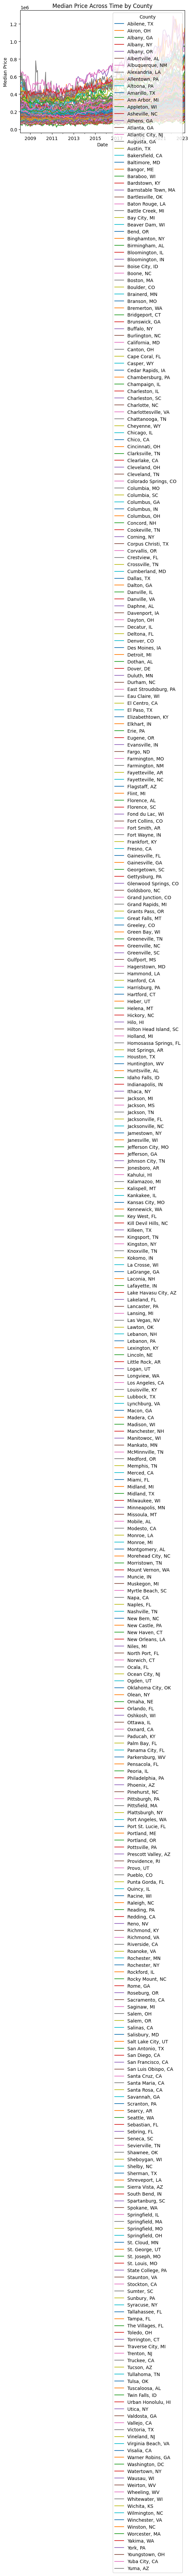

In [25]:

grouped_median_prices = df.groupby(['RegionName', 'Date'])['Median-Price'].median().unstack(level=0)

grouped_median_prices.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Median Price')
plt.title('Median Price Across Time by County')
plt.legend(title='County')
plt.show()

## Checking for stationarity

The ADF Statistic is negative and the p-value is less than the significance level (0.05). This indicates that the median sale price data is stationary. So we can proceed to creating ARIMA model without applying transformations or differencing to the data.

In [30]:
result = adfuller(df['Median-Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.256218
p-value: 0.000000


## Mean Absolute Percentage Error (MAPE):
Measures the average percentage difference between predicted and actual values.
Useful for comparing forecast accuracy across different time series.
Lower values indicate better model performance.

In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#mape = mean_absolute_percentage_error(actual_values, predicted_values)

## Return On Investment Yield (ROI Yield)